In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
# ==============================================================
# 1️⃣ Load and Preprocess Data
# ==============================================================
file_path = "emails_16_17_18_19.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully.")
    
    # Drop rows with any missing values
    df = df.dropna()

    # X: Features (word counts), y: Target (0=Not Spam, 1=Spam)
    # Using float32 for features to save memory and speed up training
    X = df.drop(columns=["Email No.", "Prediction"]).astype(np.float32).values
    y = df["Prediction"].astype(np.int8).values

    # Split data: 80% Train, 20% Test
    # stratify=y ensures the train/test split has same proportion of spam as original data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ==============================================================
    # 2️⃣ Handle Class Imbalance (Undersampling)
    # ==============================================================
    print("\nClass distribution BEFORE balancing:")
    unique, counts = np.unique(y_train, return_counts=True)
    print(dict(zip(unique, counts)))

    # Find indices of minority (Spam=1) and majority (Not Spam=0) classes
    minority_idx = np.where(y_train == 1)[0]
    majority_idx = np.where(y_train == 0)[0]

    # Randomly select same number of majority samples as minority samples
    np.random.seed(42)
    majority_downsampled_idx = np.random.choice(
        majority_idx, size=len(minority_idx), replace=False
    )

    # Combine minority and downsampled majority indices
    balanced_idx = np.concatenate([minority_idx, majority_downsampled_idx])
    np.random.shuffle(balanced_idx)

    # Create balanced training set
    X_train_bal = X_train[balanced_idx]
    y_train_bal = y_train[balanced_idx]

    print("\nClass distribution AFTER balancing (Undersampling):")
    unique_bal, counts_bal = np.unique(y_train_bal, return_counts=True)
    print(dict(zip(unique_bal, counts_bal)))

except FileNotFoundError:
    print(f"❌ Error: File '{file_path}' not found.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

✅ Dataset loaded successfully.

Class distribution BEFORE balancing:
{np.int8(0): np.int64(2937), np.int8(1): np.int64(1200)}

Class distribution AFTER balancing (Undersampling):
{np.int8(0): np.int64(1200), np.int8(1): np.int64(1200)}


In [3]:
# ==============================================================
# 3️⃣ SVM from Scratch (Linear Kernel)
# ==============================================================
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # SVM expects labels to be {-1, 1} instead of {0, 1}
        y_ = np.where(y <= 0, -1, 1)
        
        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient Descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # Hinge Loss condition: y_i * (w.x_i - b) >= 1
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                
                if condition:
                    # If correctly classified outside the margin, only regularize weights
                    # w = w - lr * (2 * lambda * w)
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # If misclassified or inside margin, update weights and bias
                    # w = w - lr * (2 * lambda * w - y_i * x_i)
                    # b = b - lr * (y_i)  <-- Note: standard derivation often uses + for b depending on formulation (w.x + b vs w.x - b)
                    # We used (w.x - b) formulation, so derivative matches.
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        # Calculate linear score: w.x - b
        approx = np.dot(X, self.w) - self.b
        # Convert back to {0, 1} labels based on sign of score
        return np.where(approx >= 0, 1, 0)

print("✅ SVM class defined successfully.")

✅ SVM class defined successfully.


In [4]:
if 'X_train_bal' in locals():
    print("Training SVM (this may take a moment)...")
    
    # Reduced iterations for speed in demonstration; increase for better accuracy
    svm_model = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=500)
    svm_model.fit(X_train_bal, y_train_bal)
    
    print("Training complete.")

Training SVM (this may take a moment)...
Training complete.


In [5]:
if 'svm_model' in locals():
    print("Evaluating on Test Set...")
    y_pred = svm_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\n========================================")
    print("📊 Model Performance Metrics")
    print("========================================")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

Evaluating on Test Set...

📊 Model Performance Metrics
Accuracy:  0.9121
Precision: 0.7802
Recall:    0.9700
F1 Score:  0.8648


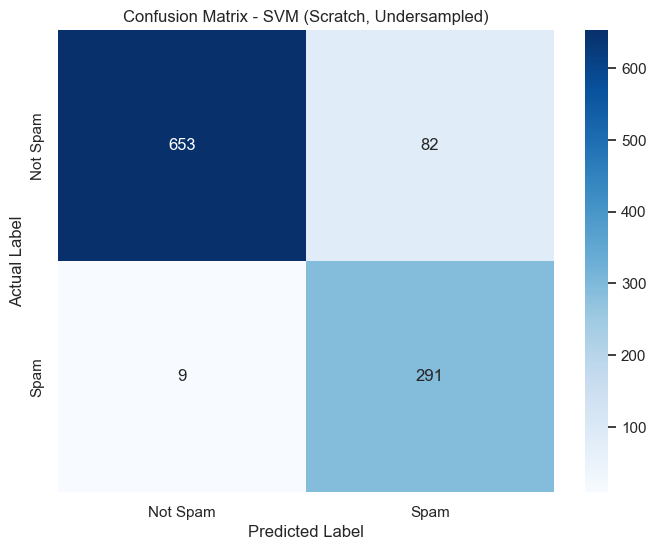

In [6]:
if 'cm' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Spam', 'Spam'], 
                yticklabels=['Not Spam', 'Spam'])
    plt.title("Confusion Matrix - SVM (Scratch, Undersampled)")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()